In [3]:
import plotly.express as px
from glob import glob
import os
import pandas as pd
import csv
import numpy as np
import seaborn as sns
from collections import defaultdict
import plotly.graph_objects as go
from matplotlib import pyplot as plt

In [4]:
img_dir = 'images'
os.makedirs(img_dir, exist_ok=True)

# DFIV Results

In [3]:
DUMP_DIR = '../dumps'
dir = 'dfiv_low_dim_parcs'

In [4]:
def get_results(dir):
    dfs = []
    root = os.path.join(DUMP_DIR, dir)
    for subdir in os.listdir(root):
        if not os.path.isdir(os.path.join(root, subdir)):
            continue
        props =  [item.split(':') for item in subdir.split('-')]
        props = {item[0]: [item[1]] for item in props}

        with open (os.path.join(root, subdir, 'result.csv'), 'r') as f:
            reader = csv.reader(f)
            mse = [float(row[0]) for row in list(reader)]
            
        n = len(mse)
        props = {key: val * n for key, val in props.items()}
        props.update({'mse': mse, 'dir': [dir] * n})
        dfs.append(pd.DataFrame(props))
    return pd.concat(dfs)

In [5]:
df_parcs =  get_results('dfiv_low_dim_parcs')
df_parcs = df_parcs.fillna(0)
# set(df.sigma)
df_parcs.sigma = ['0' if val == 'None' else val for val in df_parcs.sigma]
df_parcs['rho'] = '0.5'
set(df_parcs.sigma)

FileNotFoundError: [Errno 2] No such file or directory: '../dumps/dfiv_low_dim_parcs'

In [ ]:
df_orignal = get_results('dfiv_low_dim')
df_orignal['rho'] = '0.5'
df_orignal

In [ ]:
df_comb = pd.concat([df_parcs, df_orignal])
df_comb
df_comb = df_comb.fillna('0')
df_comb = df_comb[df_comb['rho'] == '0.5']
df_comb

In [ ]:
df_comb.loc[df_comb['dir'] == 'dfiv_low_dim', 'case'] = 'Original'
df_comb.loc[df_comb['dir'] == 'dfiv_low_dim_parcs', 'case'] = "PARCS'"
df_comb

In [ ]:
df_avg = df_comb.groupby(['data_size', 'rho', 'case', 'sigma']).mean()
df_avg = df_avg.reset_index()
df_avg = df_avg.fillna(0)
df_avg = df_avg[df_avg['rho'] == '0.5']
df_avg

In [ ]:
df_std = df_comb.groupby(['data_size', 'rho', 'case', 'sigma'])['mse'].std()
df_std = df_std.reset_index()
df_std[df_std['rho'] == '0.5']

In [ ]:
df_avg['std'] = df_std['mse']
df_avg

In [ ]:
# df_comb = df_comb.loc[df_comb['data_size'] != '1000']
df_comb

In [ ]:
fig = px.box(df_comb, x='sigma', y='mse', color = 'case', points='all',
                facet_col='data_size', facet_col_wrap=3,
                log_y=True, range_y=[90,3*10**3],
                height = 400, width = 1200,
                category_orders = {'sigma': ['0', '0.2', '1', '1.8'],
                                   'data_size': ['1000', '5000', '10000'],
                                   'rho': ['0.1', '0.5', '0.9']},
                labels={
                     "data_size": "N",
                     "mse": "MSE",
                     "case": "Case",
                     'sigma': 'Sigma'
                 })
fig.update_layout(
    font=dict(
        size=30
    ))
fig.update_yaxes(dtick=1)
fig.update_traces(width=0.6)
fig.show()
fig.write_image(f"{img_dir}/mean squared error box.pdf")

In [ ]:
fig = px.bar(df_avg, x='sigma', y='mse', barmode='group', color = 'case',
                facet_col='data_size', facet_col_wrap=3,
                height = 400, width = 1200,
                category_orders = {'sigma': ['0', '0.2', '1', '1.8'],
                                   'data_size': ['5000', '10000'],
                                   'data_size': ['1000', '5000', '10000'],
                                   'rho': ['0.1', '0.5', '0.9']},
                labels={
                     "data_size": "N",
                     "mse": "MSE",
                     "case": "Case",
                     'sigma': 'Sigma'
                 })
fig.update_xaxes(type='category')
fig.update_layout(
    font=dict(
        size=25
    )
)
fig.update_traces(width=0.3)
fig.show()
fig.write_image(f"{img_dir}/mean squared error bar.pdf")

In [ ]:
# fig = sns.FacetGrid(df, col = 'rho')
# fig.map_dataframe(sns.boxplot, x='data_size', y='mse', hue='case')
# plt.yscale('log')
# fig.set(yscale="log")
# fig.tight_layout()
# fig.add_legend()

# DFIV vs SpaceIV

In [ ]:
case = 'case_hc_num_7'
spaceiv_dir = '../MA/spaceIV'

In [ ]:
cases = [case]
res_dir = os.path.join(spaceiv_dir, 'results/comp/')
dfs = {case: pd.read_csv(os.path.join(res_dir, f'{case}.csv')) for case in cases}
df_sparseiv = dfs[case]
df_sparseiv['model'] = 'spaceIV'

In [ ]:
def read_ys(data_dir, case):
    ys = []
    for dir in os.listdir(os.path.join(data_dir, case)):
        if all(item in dir for item in ['a1', 'a2', 'a3']):
            dir = os.path.join(data_dir, case, dir)
            data_file = os.path.join(dir, 'data_size1600.csv')
            df = pd.read_csv(data_file)
            y = df['y_0'].to_numpy()
            ys.append(y)
        else:
            print(f'neglected foler {dir}')
    return np.hstack(ys)

In [ ]:
data_dir = os.path.join(spaceiv_dir, 'data')
ys = read_ys(data_dir, case)
print(f'{ys.mean()}', ys.std())

In [ ]:
# spaceIV_data_root = '../../spaceIV/data/'
# spaceIV_data_dir = os.path.join(spaceIV_data_root, case)
# print(spaceIV_data_dir)
# assert os.path.exists(spaceIV_data_dir), 'no such data'

In [ ]:
df_dfiv =  get_results('dfiv_spaceiv_vanilla')
df_dfiv['model'] = 'DFIV'
df_dfiv = df_dfiv[df_dfiv['case'] == case]

In [ ]:
df_merge = pd.concat([df_sparseiv,df_dfiv], axis=0)
df_merge

In [ ]:
df_merge.groupby('model')['mse'].mean()

In [ ]:
df_merge.groupby('model')['mse'].std()

In [ ]:
fig = px.box(df_merge, x='model', y='mse', log_y=True,
             points="all",
             height = 400, width = 800,
             labels={
                     "mode": "Algorithm",
                     "mse": "Mean Squared Error",
                 })
fig.update_layout(
    font=dict(
        size=18
    )
)
fig.show()
fig.write_image(f"{img_dir}/{case}.pdf")

# Viz Demand Dataset

In [5]:
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
plt.rcParams.update({
    "figure.figsize": [7.50, 3.50],
    "figure.autolayout": True,
    "text.usetex": False,
    "font.family": "sans-serif",
    'font.size': 16
})

data_size = 1000

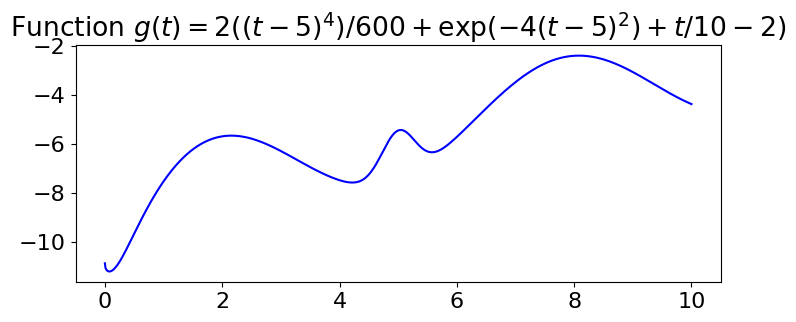

In [51]:
def psi(t: np.ndarray) -> np.ndarray:
    return 2 * (((t - 3) ** 3 )/ 500 + np.exp(-6 * ((t-5) ** 2) ) - np.sqrt(t) + np.log(25 * (t ** 2) + 5) + np.sin(t)  - 7)
    # return 2 * ((t - 5) ** 4 / 600 + np.exp(-4 * (t - 5) ** 2) + t / 10 - 2)


def f(p: np.ndarray, t: np.ndarray, s: np.ndarray) -> np.ndarray:
    return 100 + (10 + p) * s * psi(t) - 2 * p

t = np.linspace(0, 10, data_size)

plt.plot(t, psi(t), color='blue')
plt.title('Function $g(t) = 2((t-5)^4)/600 + \exp(-4(t-5)^2) + t/10 - 2)$')
plt.savefig(f'{img_dir}/time_function.pdf')
plt.show()

In [53]:
np.mean(psi(t))

-5.548802781269209

In [ ]:
min_t = 2.53379
min_psi_t = psi(min_t)
print(f'min psi(t): {min_psi_t}')
z = 3
min_p = 25 + min_psi_t * (z + 3) -3
print(f'min p: {min_p}')

max_t = 10
max_psi_t = psi(max_t)
print(f'max psi(t): {max_psi_t}')
z = 3
max_p = 25 + max_psi_t * (z + 3) + 3
print(f'max p: {max_p}')

In [ ]:
rng = np.random.default_rng(seed=0)
rho = 0.5
emotion = rng.choice(list(range(1, 8)), data_size)
time = rng.uniform(0, 10, data_size)
cost = rng.normal(0, 1.0, data_size)
noise_price = rng.normal(0, 1.0, data_size)
noise_demand = rho * noise_price + rng.normal(0, np.sqrt(1 - rho ** 2), data_size)
price = 25 + (cost + 3) * psi(time) + noise_price
structural: np.ndarray = f(price, time, emotion).astype(float)
outcome: np.ndarray = (structural + noise_demand).astype(float)

price_scale = (price - min_p) / (max_p - min_p)
sigmas = [0.2, 1, 1.8]
hetero_noise_demand = [rho * noise_price + rng.normal(0, price_scale * sigma, data_size) for sigma in sigmas]

In [ ]:
# fig = px.scatter(x=price, y=noise_demand, width=800, height=400)
# fig.update_traces(marker_size=10)
# fig.show()

In [ ]:
# from plotly.subplots import make_subplots
# import plotly.graph_objects as go

# fig = make_subplots(rows=2, cols=2, subplot_titles=(r'$\text{Demand Variance} = 1-\rho^2$ = 0.75$',
#                                                     r'$\text{Demand Variance} = r(p) * 0.2$', 
#                                                     r'$\text{Demand Variance} = r(p)$', 
#                                                     r'$\text{Demand Variance} = $r(p) * 1.8$'))

# fig.add_trace(go.Scatter(x=price, y=noise_demand, mode="markers", marker=dict(color='blue', size=10)), row=1, col=1)

# fig.add_trace(go.Scatter(x=price, y=hetero_noise_demand[0], mode="markers", marker=dict(color='blue', size=10)), row=1, col=2)

# fig.add_trace(go.Scatter(x=price, y=hetero_noise_demand[1], mode="markers", marker=dict(color='blue', size=10)), row=2, col=1)

# fig.add_trace(go.Scatter(x=price, y=hetero_noise_demand[2], mode="markers", marker=dict(color='blue', size=10)), row=2, col=2)

# fig.update_layout(height=800, width=1200, title_text="", showlegend=False)

# fig.show()

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 7))

axs[0, 0].scatter(price, noise_demand)
axs[0, 0].set_title(r'Demand Variance = $1-\rho ^2 = 0.75$')
axs[0, 0].set_ylabel('The Noise of Demand')
axs[0, 0].set_xlabel('Price')

axs[0, 1].scatter(price, hetero_noise_demand[0])
axs[0, 1].set_title(r'Demand Variance = $r(p) * 0.2$')
axs[0, 1].set_ylabel('The Noise of Demand')
axs[0, 1].set_xlabel('Price')

axs[1, 0].scatter(price, hetero_noise_demand[1])
axs[1, 0].set_title(r'Demand Variance = $r(p)$')
axs[1, 0].set_ylabel('The Noise of Demand')
axs[1, 0].set_xlabel('Price')

axs[1, 1].scatter(price, hetero_noise_demand[2])
axs[1, 1].set_title(r'Demand Variance = $r(p) * 1.8$')
axs[1, 1].set_ylabel('The Noise of Demand')
axs[1, 1].set_xlabel('Price')

fig.savefig(f'{img_dir}/demand_noise.pdf')